In [1]:
import re, json, csv, pathlib
from typing import List, Dict, Tuple
import spacy

# Choose model: 'en_core_web_trf' (better) or 'en_core_web_sm' (faster)
MODEL_NAME = "en_core_web_trf"
nlp = spacy.load(MODEL_NAME, disable=[])  # keep default ner, senter

# Where is the text? (Upload in Colab left pane or change the path)
TEXT_PATH = "../cleaned_text/vol3_02_LIFE_OF_CRASSUS.txt"

In [2]:
from pathlib import Path

raw_text = Path(TEXT_PATH).read_text(encoding="utf-8", errors="ignore")
print(raw_text[:800])  # peek

LIFE OF CRASSUS.


I. Marcus Crassus was the son of a father who had been censor, and enjoyed a triumph; but he was brought up with his two brothers in a small house. His brothers were married in the lifetime of their parents, and all had a common table, which seems to have been the chief reason that Crassus was a temperate and moderate man in his way of living. Upon the death of one of his brothers, Crassus married the widow, and she became the mother of his children; for in these matters also he lived as regular a life as any Roman. However, as he grew older, he was charged with criminal intercourse with Licinia, one of the Vestal Virgins, who was brought to trial; the prosecutor was one Plotinus. Licinia had a pleasant estate in the suburbs, which Crassus wished to get at a small price,


In [3]:
def clean_plutarch_text(t: str) -> str:
    # unify line breaks
    t = t.replace("\r\n", "\n").replace("\r", "\n")

    # drop a standalone title line like "LIFE OF CRASSUS."
    t = re.sub(
        r"^\s*LIFE OF CRASSUS\.?\s*\n+", "", t, flags=re.IGNORECASE | re.MULTILINE
    )

    # remove section headers like "I.", "II.", "XIII." when they appear as their own lines
    t = re.sub(r"(?m)^\s*[IVXLCDM]+\.\s*$", "", t)

    # collapse multiple blank lines to one
    t = re.sub(r"\n{2,}", "\n\n", t)

    # strip leading/trailing whitespace
    return t.strip()


text = clean_plutarch_text(raw_text)
print(text[:800])

I. Marcus Crassus was the son of a father who had been censor, and enjoyed a triumph; but he was brought up with his two brothers in a small house. His brothers were married in the lifetime of their parents, and all had a common table, which seems to have been the chief reason that Crassus was a temperate and moderate man in his way of living. Upon the death of one of his brothers, Crassus married the widow, and she became the mother of his children; for in these matters also he lived as regular a life as any Roman. However, as he grew older, he was charged with criminal intercourse with Licinia, one of the Vestal Virgins, who was brought to trial; the prosecutor was one Plotinus. Licinia had a pleasant estate in the suburbs, which Crassus wished to get at a small price, and with this view


In [4]:
# Geopolitical entities, locations, facilities
PLACE_LABELS = {"GPE", "LOC", "FAC"}
# People
PERSON_LABELS = {"PERSON"}
# Nationalities or religious or political groups, Organizations
OPTIONAL_LABELS = {"NORP", "ORG"}  # include if you want


def doc_entities(doc) -> List[Dict]:
    rows = []
    for ent in doc.ents:
        if ent.label_ in PERSON_LABELS | PLACE_LABELS | OPTIONAL_LABELS:
            rows.append(
                {
                    "text": ent.text,
                    "label": ent.label_,
                    "start_char": ent.start_char,
                    "end_char": ent.end_char,
                }
            )
    return rows


doc = nlp(text)  # may take ~15–30s if using transformer model on CPU
ents = doc_entities(doc)
len(ents), ents[:10]

(852,
 [{'text': 'I. Marcus Crassus',
   'label': 'PERSON',
   'start_char': 0,
   'end_char': 17},
  {'text': 'Crassus', 'label': 'PERSON', 'start_char': 283, 'end_char': 290},
  {'text': 'Crassus', 'label': 'PERSON', 'start_char': 385, 'end_char': 392},
  {'text': 'Roman', 'label': 'NORP', 'start_char': 515, 'end_char': 520},
  {'text': 'Licinia', 'label': 'PERSON', 'start_char': 595, 'end_char': 602},
  {'text': 'Plotinus', 'label': 'PERSON', 'start_char': 680, 'end_char': 688},
  {'text': 'Licinia', 'label': 'PERSON', 'start_char': 690, 'end_char': 697},
  {'text': 'Crassus', 'label': 'PERSON', 'start_char': 742, 'end_char': 749},
  {'text': 'Licinia', 'label': 'PERSON', 'start_char': 1115, 'end_char': 1122},
  {'text': 'Romans', 'label': 'NORP', 'start_char': 1177, 'end_char': 1183}])

In [5]:
from collections import Counter, defaultdict

by_label = defaultdict(Counter)
for e in ents:
    by_label[e["label"]][e["text"]] += 1

for label in sorted(by_label):
    print(f"\nTop {label}:")
    for item, cnt in by_label[label].most_common(10):
        print(f"  {item:30s}  {cnt}")


Top FAC:
  Forum                           3
  Zeugma                          1

Top GPE:
  Rome                            15
  Carrhæ                          7
  Iberia                          6
  Syria                           6
  Italy                           4
  Gaul                            4
  Mesopotamia                     4
  Armenia                         4
  Seleukeia                       3
  Capua                           2

Top LOC:
  Alps                            2
  Marsi                           1
  Straits                         1
  Lucanis                         1
  Gaul                            1
  Euphrates                       1
  Balissus                        1
  Zeugma                          1
  Scorpion                        1

Top NORP:
  Romans                          61
  Parthians                       46
  Roman                           15
  Parthian                        9
  Gauls                           5
  Armenians        

In [6]:
import pandas as pd

# map character offsets back to sentence text
sent_spans = list(doc.sents)


def find_sentence_for_span(start_char: int, end_char: int) -> str:
    for s in sent_spans:
        if s.start_char <= start_char and end_char <= s.end_char:
            return s.text.strip()
    return ""


rows = []
for e in ents:
    rows.append(
        {
            "entity": e["text"],
            "label": e["label"],
            "start_char": e["start_char"],
            "end_char": e["end_char"],
            "sentence": find_sentence_for_span(e["start_char"], e["end_char"]),
        }
    )

df = pd.DataFrame(rows)
df.to_csv("../output/crassus_ner_entities.csv", index=False)
df.head()

,entity,label,start_char,end_char,sentence
0,I. Marcus Crassus,PERSON,0,17,I. Marcus Crassus was the son of a father who ...
1,Crassus,PERSON,283,290,His brothers were married in the lifetime of t...
2,Crassus,PERSON,385,392,"Upon the death of one of his brothers, Crassus..."
3,Roman,NORP,515,520,for in these matters also he lived as regular ...
4,Licinia,PERSON,595,602,"However, as he grew older, he was charged with..."


In [7]:
def sentence_record(s) -> Dict:
    ents_in_sent = []
    for ent in s.ents:
        if ent.label_ in PERSON_LABELS | PLACE_LABELS | OPTIONAL_LABELS:
            ents_in_sent.append(
                {
                    "text": ent.text,
                    "label": ent.label_,
                    "start": ent.start_char - s.start_char,
                    "end": ent.end_char - s.start_char,
                }
            )
    return {"sentence": s.text.strip(), "entities": ents_in_sent}


jsonl_path = "../output/crassus_sentences_ner.jsonl"
with open(jsonl_path, "w", encoding="utf-8") as f:
    for s in doc.sents:
        rec = sentence_record(s)
        json.dump(rec, f, ensure_ascii=False)
        f.write("\n")

print("Wrote:", jsonl_path)

Wrote: ../output/crassus_sentences_ner.jsonl


In [8]:
TAG_MAP = {
    "PERSON": ("<PERSON>", "</PERSON>"),
    "GPE": ("<PLACE>", "</PLACE>"),
    "LOC": ("<PLACE>", "</PLACE>"),
    "FAC": ("<PLACE>", "</PLACE>"),
    "NORP": ("<GROUP>", "</GROUP>"),
    "ORG": ("<ORG>", "</ORG>"),
}


def inline_tag_text(d) -> str:
    # Build insertion points from character offsets; walk from end to start so offsets remain valid
    inserts = []
    for ent in d.ents:
        if ent.label_ in TAG_MAP:
            open_tag, close_tag = TAG_MAP[ent.label_]
            inserts.append((ent.start_char, open_tag))
            inserts.append((ent.end_char, close_tag))
    # sort by position descending so we can splice safely
    inserts.sort(key=lambda x: x[0], reverse=True)
    txt = d.text
    for pos, tag in inserts:
        txt = txt[:pos] + tag + txt[pos:]
    return txt


tagged = inline_tag_text(doc)
out_path = "../output/crassus_inline_ner.txt"
Path(out_path).write_text(tagged, encoding="utf-8")
print("Wrote:", out_path)
print(tagged[:600])

Wrote: ../output/crassus_inline_ner.txt
<PERSON>I. Marcus Crassus</PERSON> was the son of a father who had been censor, and enjoyed a triumph; but he was brought up with his two brothers in a small house. His brothers were married in the lifetime of their parents, and all had a common table, which seems to have been the chief reason that <PERSON>Crassus</PERSON> was a temperate and moderate man in his way of living. Upon the death of one of his brothers, <PERSON>Crassus</PERSON> married the widow, and she became the mother of his children; for in these matters also he lived as regular a life as any <GROUP>Roman</GROUP>. However, as 


In [9]:
from spacy import displacy

# Render just the first ~10 sentences so it stays readable
preview_doc = nlp(" ".join([s.text for s in list(doc.sents)[:10]]))
displacy.render(preview_doc, style="ent", jupyter=True, options={"compact": True})

Nodes: 93, Edges: 160
Wrote: crassus_network_edges.csv, crassus_network_nodes.csv, crassus_network.gexf


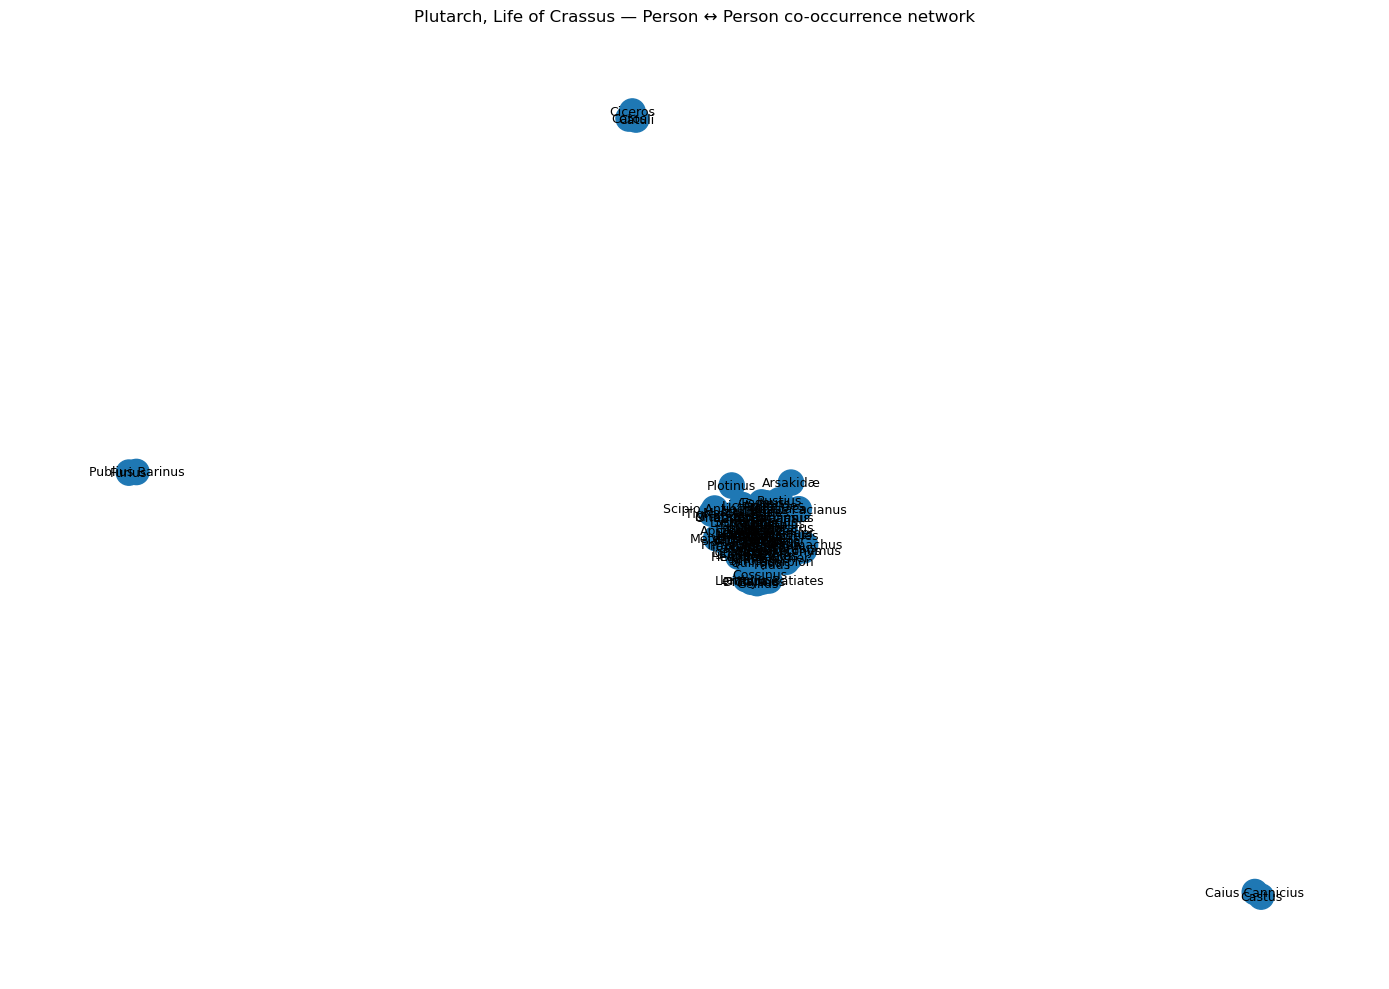

In [10]:
# --- CONFIG ---
JSONL_PATH = "../output/crassus_sentences_ner.jsonl"
NETWORK_MODE = "person_person"  # or "person_place"
MIN_EDGE_WEIGHT = 1  # hide very rare co-occurrences in the drawing
FIGSIZE = (14, 10)

# --- LOAD ---
import json, pandas as pd, itertools, collections, math, pathlib
import networkx as nx
import matplotlib.pyplot as plt

records = []
with open(JSONL_PATH, "r", encoding="utf-8") as f:
    for line in f:
        records.append(json.loads(line))


# --- COLLECT ENTITIES PER SENTENCE ---
def keep_ent(e):
    if NETWORK_MODE == "person_person":
        return e["label"] == "PERSON"
    if NETWORK_MODE == "person_place":
        return (e["label"] == "PERSON") or (e["label"] in {"GPE", "LOC", "FAC"})
    return False


sents = []
for r in records:
    ents = [(e["text"].strip(), e["label"]) for e in r["entities"] if keep_ent(e)]
    # de-duplicate identical mentions within a sentence to avoid self-inflation
    ents = list(dict.fromkeys(ents))
    if len(ents) >= 2:
        sents.append(ents)

# --- BUILD EDGES ---
edge_counts = collections.Counter()
node_labels = {}  # name -> label
for ents in sents:
    if NETWORK_MODE == "person_person":
        pairs = itertools.combinations([e for e in ents if e[1] == "PERSON"], 2)
    else:  # person_place
        persons = [e for e in ents if e[1] == "PERSON"]
        places = [e for e in ents if e[1] in {"GPE", "LOC", "FAC"}]
        pairs = itertools.product(persons, places)

    for (a, al), (b, bl) in pairs:
        if a == b:
            continue
        u, v = sorted([a, b])  # undirected
        edge_counts[(u, v)] += 1
        node_labels[u] = node_labels.get(u, al)
        node_labels[v] = node_labels.get(v, bl)

# --- GRAPH ---
G = nx.Graph()
for n, lab in node_labels.items():
    G.add_node(n, label=lab, type=("PERSON" if lab == "PERSON" else "PLACE"))

for (u, v), w in edge_counts.items():
    G.add_edge(u, v, weight=int(w))

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

# --- EXPORT TABLES ---
edges_df = pd.DataFrame(
    [(u, v, d["weight"]) for u, v, d in G.edges(data=True)],
    columns=["source", "target", "weight"],
).sort_values("weight", ascending=False)
nodes_df = pd.DataFrame(
    [
        (
            n,
            d["label"],
            d["type"],
            G.degree(n),
            sum(w for *_, w in G.edges(n, data="weight")),
        )
        for n, d in G.nodes(data=True)
    ],
    columns=["node", "label", "type", "degree", "strength"],
).sort_values("strength", ascending=False)

edges_df.to_csv("../output/crassus_network_edges.csv", index=False)
nodes_df.to_csv("../output/crassus_network_nodes.csv", index=False)
nx.write_gexf(G, "../output/crassus_network.gexf")
print(
    "Wrote: crassus_network_edges.csv, crassus_network_nodes.csv, crassus_network.gexf"
)

# --- DRAW (matplotlib, single plot, no custom colors) ---
plt.figure(figsize=FIGSIZE)
# layout that respects edge weights a bit
pos = nx.spring_layout(
    G,
    k=0.6 / math.sqrt(max(1, G.number_of_nodes())),
    iterations=100,
    weight="weight",
    seed=7,
)

# node sizes by strength
strength = nodes_df.set_index("node")["strength"].to_dict()
sizes = [300 + 30 * math.sqrt(strength.get(n, 1)) for n in G.nodes()]

# separate persons and places for legend
persons = [n for n, d in G.nodes(data=True) if d["type"] == "PERSON"]
places = [n for n, d in G.nodes(data=True) if d["type"] == "PLACE"]

# edges: show only above threshold
draw_edges = [(u, v) for u, v, w in G.edges(data="weight") if w >= MIN_EDGE_WEIGHT]
widths = [max(1, math.log2(G[u][v]["weight"] + 1)) for (u, v) in draw_edges]

nx.draw_networkx_edges(G, pos, edgelist=draw_edges, width=widths, alpha=0.4)
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=persons,
    node_size=[sizes[list(G.nodes()).index(n)] for n in persons],
)
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=places,
    node_shape="s",
    node_size=[sizes[list(G.nodes()).index(n)] for n in places],
)
nx.draw_networkx_labels(G, pos, font_size=9)

plt.title(
    f"Plutarch, Life of Crassus — {NETWORK_MODE.replace('_',' ↔ ').title()} co-occurrence network"
)
plt.axis("off")
plt.tight_layout()
plt.savefig("../output/crassus_network.png", dpi=200)
plt.show()

In [11]:
# --- CONFIG ---
JSONL_PATH = "../output/crassus_sentences_ner.jsonl"
NORMALIZATION_CSV = "../output/place_normalization.csv"  # optional; will create a template if missing
SAMPLE_SENTENCES_PER_MARKER = 2

import os, json, time, pandas as pd, pathlib, collections
from pathlib import Path

with open(JSONL_PATH, "r", encoding="utf-8") as f:
    rows = [json.loads(line) for line in f]

# Collect raw place mentions and a few example sentences
examples = collections.defaultdict(list)
counts   = collections.Counter()

for r in rows:
    sent = r["sentence"]
    for e in r["entities"]:
        if e["label"] in {"GPE","LOC","FAC"}:
            name = e["text"].strip()
            counts[name] += 1
            if len(examples[name]) < SAMPLE_SENTENCES_PER_MARKER:
                examples[name].append(sent.strip())

places_df = pd.DataFrame(
    {"place": list(counts.keys()), "count": list(counts.values())}
).sort_values("count", ascending=False)

# --- Normalization pass (optional) ---
# Create a CSV template on first run so students can edit mappings.
if not Path(NORMALIZATION_CSV).exists():
    tmpl = places_df.copy()
    tmpl["normalized"] = tmpl["place"]  # start as identity mapping
    tmpl.to_csv(NORMALIZATION_CSV, index=False)
    print(f"Created template for normalization: {NORMALIZATION_CSV}  (edit 'normalized' column as needed)")

norm_df = pd.read_csv(NORMALIZATION_CSV)
norm_map = dict(zip(norm_df["place"], norm_df["normalized"]))
places_df["normalized"] = places_df["place"].map(norm_map).fillna(places_df["place"])

# Attach example sentences
places_df["examples"] = places_df["place"].map(lambda p: examples[p])

# --- Geocode (polite) with caching ---
!pip -q install geopy folium

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import pickle

cache_path = "../output/geocode_cache.pkl"
if Path(cache_path).exists():
    with open(cache_path, "rb") as f:
        geocode_cache = pickle.load(f)
else:
    geocode_cache = {}

user_agent = "crassus-ner-mapping/1.0 (for coursework)"
geolocator = Nominatim(user_agent=user_agent, timeout=10)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)  # be nice

def geocode_name(name: str):
    if name in geocode_cache:
        return geocode_cache[name]
    try:
        loc = geocode(name)
        if loc:
            geocode_cache[name] = (loc.latitude, loc.longitude, loc.address)
        else:
            geocode_cache[name] = (None, None, None)
    except Exception as e:
        geocode_cache[name] = (None, None, None)
    return geocode_cache[name]

lat, lon, addr = [], [], []
for name in places_df["normalized"]:
    la, lo, ad = geocode_name(name)
    lat.append(la); lon.append(lo); addr.append(ad)

with open(cache_path, "wb") as f:
    pickle.dump(geocode_cache, f)

places_df["lat"] = lat
places_df["lon"] = lon
places_df["address"] = addr

# Save a tidy CSV (good for grading / debugging)
places_df.to_csv("../output/crassus_places.csv", index=False)
print("Wrote: crassus_places.csv")

# --- Build a Folium map ---
import folium
from folium.plugins import MarkerCluster

valid = places_df.dropna(subset=["lat","lon"])
if valid.empty:
    raise SystemExit("No geocoded places found. Edit 'place_normalization.csv' to use modern names (e.g., 'Carrhae' → 'Harran').")

center = [valid["lat"].mean(), valid["lon"].mean()]
m = folium.Map(location=center, zoom_start=4, tiles="OpenStreetMap")

cluster = MarkerCluster().add_to(m)
for _, row in valid.iterrows():
    examples_html = "<br><br>".join([f"• {s}" for s in row["examples"]])
    popup_html = f"""
    <b>{row['place']}</b> → <i>{row['normalized']}</i><br>
    <b>Mentions:</b> {row['count']}<br>
    <b>Geocoder:</b> {row['address'] or '—'}<br><br>
    <b>Examples:</b><br>{examples_html}
    """
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=5 + min(15, row["count"]),  # slightly scale by frequency
        fill=True,
        popup=folium.Popup(popup_html, max_width=450),
        tooltip=f"{row['place']} ({row['count']})"
    ).add_to(cluster)

map_path = "../output/crassus_map.html"
m.save(map_path)
print("Wrote:", map_path)


Created template for normalization: ../output/place_normalization.csv  (edit 'normalized' column as needed)
Wrote: crassus_places.csv
Wrote: ../output/crassus_map.html


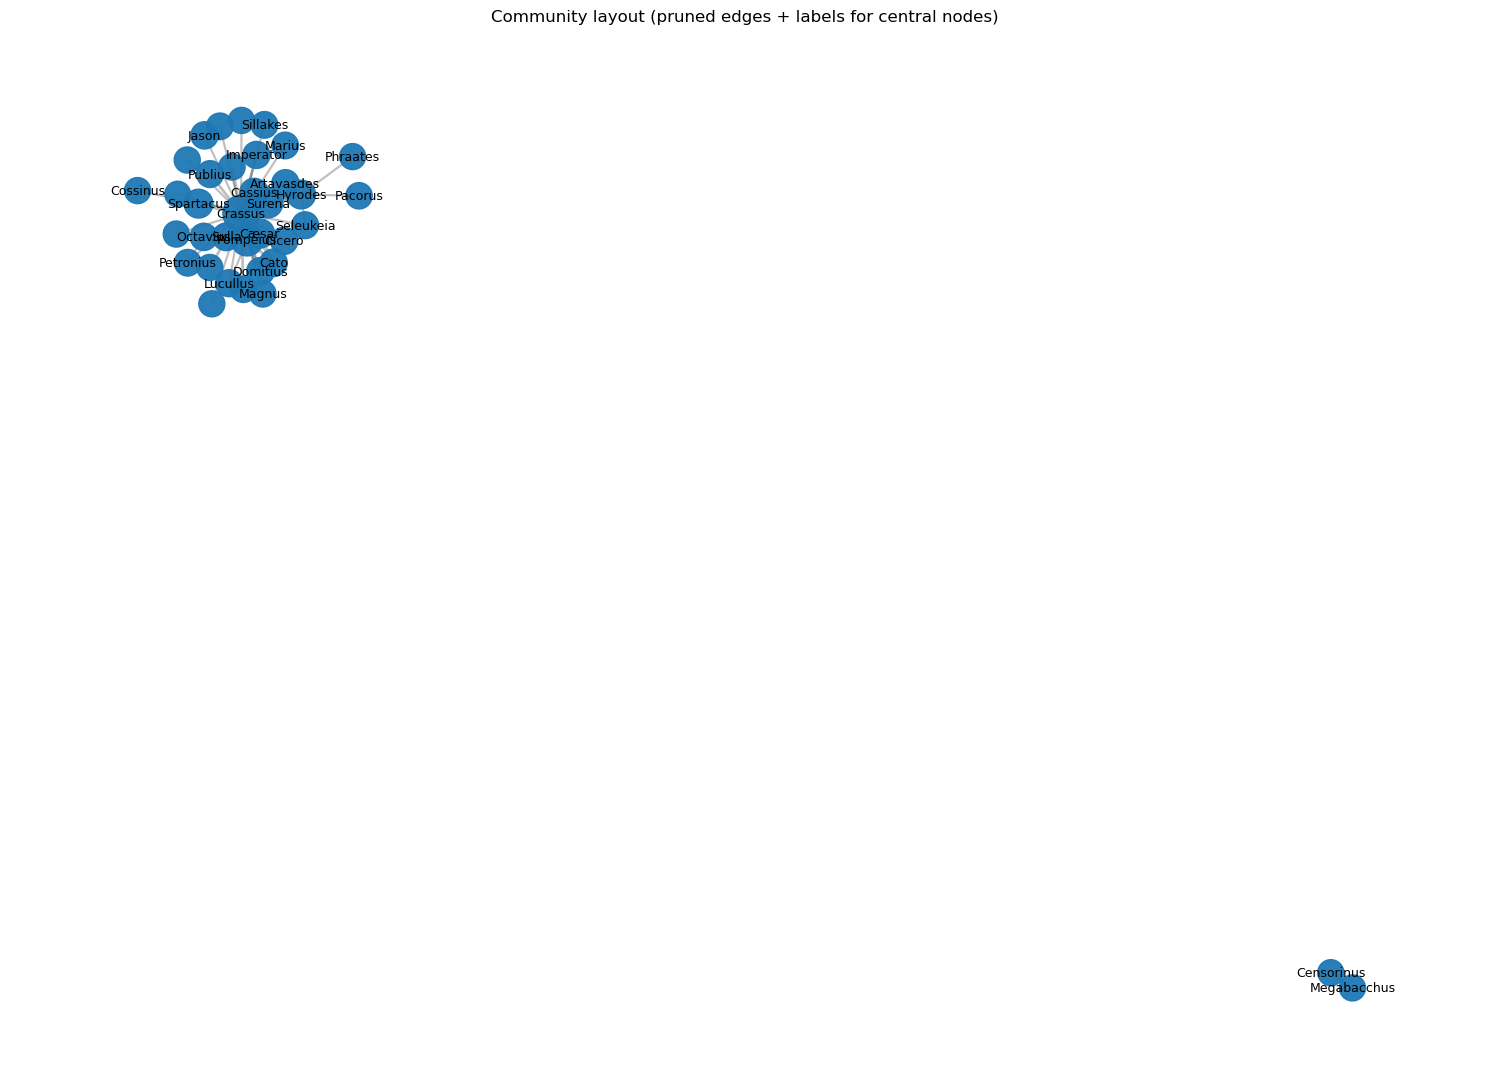

In [12]:
from networkx.algorithms.community import greedy_modularity_communities
import math, random

# Work on the main graph G but prune weak edges
PRUNE_WEIGHT = 2
G2 = nx.Graph(
    (u, v, d) for u, v, d in G.edges(data=True) if d["weight"] >= PRUNE_WEIGHT
)

# Detect communities
comms = list(greedy_modularity_communities(G2))
comm_index = {}
for i, c in enumerate(comms):
    for n in c:
        comm_index[n] = i

# Node sizes by strength
strength = nodes_df.set_index("node")["strength"].to_dict()
sizes = [300 + 30 * math.sqrt(strength.get(n, 1)) for n in G2.nodes()]

# Layout
pos = nx.spring_layout(
    G2,
    k=0.6 / math.sqrt(max(1, G2.number_of_nodes())),
    iterations=200,
    weight="weight",
    seed=7,
)

plt.figure(figsize=(15, 11))

# Draw edges light
widths = [max(0.5, math.log2(d["weight"] + 1)) for *_, d in G2.edges(data=True)]
nx.draw_networkx_edges(G2, pos, width=widths, alpha=0.25)

# Draw nodes by community (no custom colors specified; rely on defaults)
for i, c in enumerate(comms):
    nx.draw_networkx_nodes(
        G2,
        pos,
        nodelist=list(c),
        node_size=[sizes[list(G2.nodes()).index(n)] for n in c],
        alpha=0.95,
    )

# Label only the top few nodes per community by strength
LABELS_PER_COMM = 8
labels = {}
for i, c in enumerate(comms):
    top = sorted(list(c), key=lambda n: strength.get(n, 0), reverse=True)[
        :LABELS_PER_COMM
    ]
    for n in top:
        labels[n] = n
nx.draw_networkx_labels(G2, pos, labels=labels, font_size=9)

plt.title("Community layout (pruned edges + labels for central nodes)")
plt.axis("off")
plt.tight_layout()
plt.show()